# 🔽 Downsampling de Datos Supervisados: 500Hz → 200Hz

Este notebook reduce la frecuencia de muestreo de los datos ECG supervisados de **500Hz a 200Hz**.

**¿Qué hace?**
- Lee los datos desde `Datos_supervisados/numpy/` y `Datos_supervisados/tensors/`
- Reduce cada señal de **5000 muestras** (10 seg @ 500Hz) a **2000 muestras** (10 seg @ 200Hz)
- Guarda los nuevos archivos con sufijo `_200hz` o sobrescribe (configurable)
- Mantiene la estructura original: `(N, 2000, 3)` donde 3 son los leads (II, V1, V5)

**Ventajas:**
- ✅ No necesitas reprocesar desde los datos originales
- ✅ Mantiene los splits train/val/test
- ✅ Conserva el preprocesado (filtrado, normalización)
- ✅ Reduce el tamaño de archivos ~2.5x (menos memoria)

**Método:** Usa `scipy.signal.resample` que aplica filtrado anti-aliasing automáticamente.


## 📋 Índice

1. **Configuración** - Rutas y parámetros
2. **Imports y dependencias** - Librerías necesarias
3. **Función de downsampling** - Lógica principal
4. **Procesar archivos numpy** - Downsampling de .npy
5. **Procesar tensores PyTorch** - Downsampling de .pt
6. **Verificación** - Comprobar resultados


## 1. ⚙️ Configuración


In [1]:
# ========================================
# CONFIGURACIÓN
# ========================================
from pathlib import Path

# Ruta a la carpeta de datos supervisados
DATA_DIR = Path("../data/Datos_supervisados")

# Frecuencias de muestreo
ORIGINAL_FS = 500  # Hz original
TARGET_FS = 200    # Hz objetivo

# Duración de cada señal (segundos)
SIGNAL_DURATION = 10  # segundos

# Calcular número de muestras
ORIGINAL_SAMPLES = int(SIGNAL_DURATION * ORIGINAL_FS)  # 5000
TARGET_SAMPLES = int(SIGNAL_DURATION * TARGET_FS)      # 2000

# Opciones de guardado
OVERWRITE_ORIGINAL = False  # Si True, sobrescribe archivos originales
                           # Si False, guarda con sufijo "_200hz"

# Guardar en carpeta separada (recomendado para mantener originales intactos)
USE_SEPARATE_FOLDER = True  # Si True, crea carpetas numpy_200hz/ y tensors_200hz/
                            # Si False, guarda en las mismas carpetas con sufijo

# Procesar en chunks para ahorrar memoria y guardar incrementalmente
# Si None, procesa todo de una vez (más lento pero más simple)
# Recomendado: 5000-10000 para balance entre velocidad y memoria
CHUNK_SIZE = 10000  # Número de muestras por chunk (ej: 10000)

print("=" * 80)
print("CONFIGURACIÓN DE DOWNSAMPLING")
print("=" * 80)
print(f"📁 Directorio de datos: {DATA_DIR.resolve()}")
print(f"📊 Frecuencia original: {ORIGINAL_FS} Hz ({ORIGINAL_SAMPLES} muestras)")
print(f"📊 Frecuencia objetivo:  {TARGET_FS} Hz ({TARGET_SAMPLES} muestras)")
print(f"📉 Factor de reducción:  {ORIGINAL_FS / TARGET_FS:.2f}x")
print(f"💾 Sobrescribir originales: {OVERWRITE_ORIGINAL}")
print(f"📁 Usar carpeta separada: {USE_SEPARATE_FOLDER}")
if CHUNK_SIZE:
    print(f"📦 Procesar en chunks de: {CHUNK_SIZE} muestras (guardado incremental)")
else:
    print(f"📦 Procesar todo de una vez (más lento, requiere más memoria)")
print("=" * 80)


CONFIGURACIÓN DE DOWNSAMPLING
📁 Directorio de datos: S:\Proyecto final\data\Datos_supervisados
📊 Frecuencia original: 500 Hz (5000 muestras)
📊 Frecuencia objetivo:  200 Hz (2000 muestras)
📉 Factor de reducción:  2.50x
💾 Sobrescribir originales: False
📁 Usar carpeta separada: True
📦 Procesar en chunks de: 10000 muestras (guardado incremental)


## 2. 📦 Imports y Dependencias


In [7]:
import numpy as np
import torch
from scipy.signal import resample
from pathlib import Path
import time
import shutil

# Intentar importar tqdm, si no está disponible usar progreso simple
try:
    from tqdm import tqdm
    HAS_TQDM = True
except ImportError:
    HAS_TQDM = False
    # Crear función tqdm simple como fallback
    def tqdm(iterable, desc=""):
        """Fallback simple para tqdm si no está instalado."""
        return iterable

print("✓ Librerías importadas correctamente")
print(f"  NumPy: {np.__version__}")
print(f"  PyTorch: {torch.__version__}")
if HAS_TQDM:
    print(f"  tqdm: Disponible (barra de progreso)")
else:
    print(f"  tqdm: No disponible (usando progreso simple)")


✓ Librerías importadas correctamente
  NumPy: 2.2.6
  PyTorch: 2.10.0.dev20251121+cu128
  tqdm: Disponible (barra de progreso)


## 3. 🔧 Función de Downsampling


In [12]:
def downsample_and_save_incremental(
    X: np.ndarray, 
    target_samples: int, 
    output_file: Path,
    chunk_size: int = 10000
) -> tuple:
    """
    Reduce la frecuencia de muestreo y guarda incrementalmente en chunks.
    Más eficiente en memoria y permite recuperar progreso.
    
    Args:
        X: Array de forma (N, T, C) con mmap_mode='r' o array normal
        target_samples: Número objetivo de timesteps (2000)
        output_file: Archivo donde guardar el resultado
        chunk_size: Tamaño de cada chunk a procesar
    
    Returns:
        Tuple con (shape_original, shape_final, tiempo_total)
    """
    if X.ndim != 3:
        raise ValueError(f"Se espera array 3D, pero se recibió {X.ndim}D")
    
    N, T, C = X.shape
    n_chunks = (N + chunk_size - 1) // chunk_size
    
    print(f"  Procesando {N} señales en {n_chunks} chunks de ~{chunk_size}...")
    print(f"  Guardando incrementalmente en {output_file.name}...")
    
    # Crear directorio si no existe
    output_file.parent.mkdir(parents=True, exist_ok=True)
    
    # Procesar y guardar chunk por chunk de forma más eficiente
    all_chunks = []
    start_time = time.time()
    checkpoint_file = output_file.parent / f".temp_{output_file.stem}_checkpoint.npy"
    
    # Crear iterador con progreso
    chunk_range = range(0, N, chunk_size)
    if not HAS_TQDM:
        print(f"  Procesando {len(chunk_range)} chunks...")
    
    for i, chunk_start in enumerate(tqdm(chunk_range, desc="  Procesando chunks")):
        chunk_end = min(chunk_start + chunk_size, N)
        
        # Leer chunk (desde mmap, muy eficiente)
        chunk = np.array(X[chunk_start:chunk_end])  # Copiar a memoria para procesar
        
        # Aplicar downsampling
        chunk_down = resample(chunk, target_samples, axis=1).astype(np.float32)
        del chunk  # Liberar inmediatamente
        
        # Acumular chunk
        all_chunks.append(chunk_down)
        
        # Cada 5 chunks o al final, guardar checkpoint y limpiar memoria
        if (i + 1) % 5 == 0 or chunk_end == N:
            # Concatenar chunks acumulados desde último checkpoint
            if len(all_chunks) > 0:
                new_chunks = np.concatenate(all_chunks, axis=0)
                
                # Cargar checkpoint anterior si existe
                if checkpoint_file.exists():
                    previous = np.load(checkpoint_file)
                    accumulated = np.concatenate([previous, new_chunks], axis=0)
                    checkpoint_file.unlink()  # Eliminar checkpoint anterior
                else:
                    accumulated = new_chunks
                
                # Guardar nuevo checkpoint (siempre, para poder reanudar)
                np.save(checkpoint_file, accumulated)
                progress_pct = 100 * len(accumulated) / N
                if HAS_TQDM:
                    # tqdm ya muestra el progreso, solo mensaje breve
                    print(f"    💾 Checkpoint guardado: {len(accumulated)}/{N} muestras ({progress_pct:.1f}%)")
                else:
                    # Sin tqdm, mostrar progreso más detallado
                    print(f"    💾 Checkpoint: {len(accumulated)}/{N} muestras ({progress_pct:.1f}%) - Chunk {i+1}/{len(chunk_range)}")
                
                all_chunks = []  # Limpiar lista para ahorrar memoria
                del new_chunks
    
    # Cargar resultado final desde checkpoint
    if checkpoint_file.exists():
        accumulated = np.load(checkpoint_file)
        checkpoint_file.unlink()
    else:
        # Si no hay checkpoint, concatenar chunks restantes (caso edge)
        if len(all_chunks) > 0:
            accumulated = np.concatenate(all_chunks, axis=0)
        else:
            raise ValueError("No se procesaron chunks")
    
    # Guardar archivo final
    print(f"  💾 Guardando archivo final ({len(accumulated)} muestras)...")
    np.save(output_file, accumulated)
    
    # Limpiar checkpoints temporales si quedan
    for temp_file in output_file.parent.glob(f".temp_{output_file.stem}_*"):
        if temp_file.exists():
            temp_file.unlink()
    
    elapsed = time.time() - start_time
    
    return (X.shape, accumulated.shape, elapsed)


def get_output_filename(original_file: Path, overwrite: bool, use_separate_folder: bool) -> Path:
    """
    Genera el nombre del archivo de salida.
    
    Args:
        original_file: Archivo original
        overwrite: Si True, sobrescribe el original
        use_separate_folder: Si True, guarda en carpeta separada (numpy_200hz/ o tensors_200hz/)
    
    Returns:
        Path al archivo de salida
    """
    if overwrite:
        return original_file
    elif use_separate_folder:
        # Crear carpeta separada con sufijo _200hz
        parent_dir = original_file.parent
        folder_name = parent_dir.name + "_200hz"
        output_dir = parent_dir.parent / folder_name
        output_dir.mkdir(parents=True, exist_ok=True)
        return output_dir / original_file.name
    else:
        # Añadir sufijo antes de la extensión en la misma carpeta
        return original_file.parent / f"{original_file.stem}_200hz{original_file.suffix}"


print("✓ Funciones definidas")


✓ Funciones definidas


## 4. 📊 Procesar Archivos NumPy (.npy)


In [13]:
# ========================================
# Procesar archivos numpy
# ========================================
numpy_dir = DATA_DIR / "numpy"

if not numpy_dir.exists():
    print(f"❌ Error: No se encuentra {numpy_dir}")
    raise FileNotFoundError(f"Directorio no encontrado: {numpy_dir}")

print(f"\n{'='*80}")
print("PROCESANDO ARCHIVOS NUMPY (.npy)")
print(f"{'='*80}")

splits = ['train', 'val', 'test']
numpy_results = {}

for split in splits:
    print(f"\n📂 Procesando {split}...")
    
    # Archivo de entrada
    input_file = numpy_dir / f"X_{split}.npy"
    
    if not input_file.exists():
        print(f"  ⚠️ Archivo no encontrado: {input_file.name}, saltando...")
        continue
    
    # Generar nombre de archivo de salida
    output_file = get_output_filename(input_file, OVERWRITE_ORIGINAL, USE_SEPARATE_FOLDER)
    
    # Verificar si ya existe (para poder reanudar)
    if output_file.exists():
        print(f"  ⚠️ Archivo de salida ya existe: {output_file.name}")
        respuesta = input(f"  ¿Sobrescribir? (s/n): ").lower().strip()
        if respuesta != 's':
            print(f"  ⏭️ Saltando {split}...")
            continue
    
    # Cargar datos (usar mmap para ahorrar memoria - no carga todo en RAM)
    print(f"  📥 Cargando {input_file.name} (modo mmap, no carga todo en memoria)...")
    X = np.load(input_file, mmap_mode='r')
    
    print(f"  📊 Shape original: {X.shape}")
    print(f"  💾 Tamaño total: {X.nbytes / 1024**3:.2f} GB (usando mmap)")
    
    # Verificar que tiene la forma esperada
    if X.ndim != 3:
        print(f"  ❌ Error: Se espera array 3D, pero tiene {X.ndim} dimensiones")
        continue
    
    if X.shape[1] != ORIGINAL_SAMPLES:
        print(f"  ⚠️ Advertencia: Se esperaban {ORIGINAL_SAMPLES} timesteps, pero hay {X.shape[1]}")
    
    # Aplicar downsampling y guardar incrementalmente
    print(f"  🔽 Aplicando downsampling {ORIGINAL_SAMPLES} → {TARGET_SAMPLES}...")
    input_shape, output_shape, elapsed = downsample_and_save_incremental(
        X, TARGET_SAMPLES, output_file, chunk_size=CHUNK_SIZE or 10000
    )
    
    # Calcular tamaños
    input_size_gb = np.prod(input_shape) * 4 / 1024**3  # float32 = 4 bytes
    output_size_gb = np.prod(output_shape) * 4 / 1024**3
    
    print(f"  📊 Shape nueva: {output_shape}")
    print(f"  💾 Tamaño nuevo: {output_size_gb:.2f} GB")
    print(f"  ✅ Completado en {elapsed:.2f} segundos ({elapsed/60:.2f} minutos)")
    
    numpy_results[split] = {
        'input_shape': input_shape,
        'output_shape': output_shape,
        'input_size_gb': input_size_gb,
        'output_size_gb': output_size_gb,
        'time_seconds': elapsed,
        'output_file': output_file
    }
    
    # Liberar memoria
    del X

print(f"\n{'='*80}")
print("✓ PROCESAMIENTO NUMPY COMPLETADO")
print(f"{'='*80}")

# ========================================
# Copiar archivos y (etiquetas) - NO necesitan downsampling
# ========================================
print(f"\n{'='*80}")
print("📋 COPIANDO ARCHIVOS Y (ETIQUETAS)")
print(f"{'='*80}")
print("ℹ️  Los archivos y contienen etiquetas (0/1), no señales, por lo que")
print("   solo se copian a la nueva carpeta sin procesamiento.\n")

y_results = {}

for split in splits:
    y_file = numpy_dir / f"y_{split}.npy"
    
    if not y_file.exists():
        print(f"  ⚠️ Archivo no encontrado: {y_file.name}, saltando...")
        continue
    
    # Generar nombre de archivo de salida (misma lógica que X)
    y_output_file = get_output_filename(y_file, OVERWRITE_ORIGINAL, USE_SEPARATE_FOLDER)
    
    # Verificar si ya existe
    if y_output_file.exists() and not OVERWRITE_ORIGINAL:
        print(f"  ✓ {y_file.name} ya existe en {y_output_file.parent.name}/, saltando...")
        y_results[split] = {'copied': False, 'file': y_output_file}
        continue
    
    # Copiar archivo (no necesita procesamiento)
    print(f"  📋 Copiando {y_file.name} → {y_output_file.parent.name}/{y_output_file.name}...")
    shutil.copy2(y_file, y_output_file)
    
    # Verificar que se copió correctamente
    if y_output_file.exists():
        print(f"  ✅ Copiado exitosamente")
        y_results[split] = {'copied': True, 'file': y_output_file}
    else:
        print(f"  ❌ Error al copiar")
        y_results[split] = {'copied': False, 'file': y_output_file}

print(f"\n{'='*80}")
print("✓ ARCHIVOS Y COPIADOS")
print(f"{'='*80}")



PROCESANDO ARCHIVOS NUMPY (.npy)

📂 Procesando train...
  ⚠️ Archivo de salida ya existe: X_train.npy
  ⏭️ Saltando train...

📂 Procesando val...
  ⚠️ Archivo de salida ya existe: X_val.npy
  ⏭️ Saltando val...

📂 Procesando test...
  ⚠️ Archivo de salida ya existe: X_test.npy
  ⏭️ Saltando test...

✓ PROCESAMIENTO NUMPY COMPLETADO

📋 COPIANDO ARCHIVOS Y (ETIQUETAS)
ℹ️  Los archivos y contienen etiquetas (0/1), no señales, por lo que
   solo se copian a la nueva carpeta sin procesamiento.

  📋 Copiando y_train.npy → numpy_200hz/y_train.npy...
  ✅ Copiado exitosamente
  📋 Copiando y_val.npy → numpy_200hz/y_val.npy...
  ✅ Copiado exitosamente
  📋 Copiando y_test.npy → numpy_200hz/y_test.npy...
  ✅ Copiado exitosamente

✓ ARCHIVOS Y COPIADOS


In [ ]:
# ========================================
# Procesar tensores PyTorch
# ========================================
tensors_dir = DATA_DIR / "tensors"

if not tensors_dir.exists():
    print(f"❌ Error: No se encuentra {tensors_dir}")
    print("⚠️ Saltando procesamiento de tensores...")
else:
    print(f"\n{'='*80}")
    print("PROCESANDO TENSORES PYTORCH (.pt)")
    print(f"{'='*80}")
    
    tensor_results = {}
    
    for split in splits:
        print(f"\n📂 Procesando {split}...")
        
        # Archivo de entrada
        input_file = tensors_dir / f"X_{split}.pt"
        
        if not input_file.exists():
            print(f"  ⚠️ Archivo no encontrado: {input_file.name}, saltando...")
            continue
        
        # Generar nombre de archivo de salida
        output_file = get_output_filename(input_file, OVERWRITE_ORIGINAL, USE_SEPARATE_FOLDER)
        
        # Verificar si ya existe
        if output_file.exists():
            print(f"  ⚠️ Archivo de salida ya existe: {output_file.name}")
            respuesta = input(f"  ¿Sobrescribir? (s/n): ").lower().strip()
            if respuesta != 's':
                print(f"  ⏭️ Saltando {split}...")
                continue
        
        # Cargar tensor (para tensores no podemos usar mmap, pero procesamos en chunks)
        print(f"  📥 Cargando {input_file.name}...")
        start_time = time.time()
        X = torch.load(input_file, map_location='cpu')
        
        print(f"  📊 Shape original: {X.shape}")
        original_shape = X.shape
        original_size_gb = X.element_size() * X.nelement() / 1024**3
        print(f"  💾 Tamaño en memoria: {original_size_gb:.2f} GB")
        
        # Verificar que tiene la forma esperada
        if X.ndim != 3:
            print(f"  ❌ Error: Se espera tensor 3D, pero tiene {X.ndim} dimensiones")
            continue
        
        if X.shape[1] != ORIGINAL_SAMPLES:
            print(f"  ⚠️ Advertencia: Se esperaban {ORIGINAL_SAMPLES} timesteps, pero hay {X.shape[1]}")
        
        # Convertir a numpy y procesar incrementalmente
        print(f"  🔄 Convirtiendo a numpy...")
        X_np = X.numpy()
        del X  # Liberar tensor de memoria
        
        # Aplicar downsampling y guardar incrementalmente (como numpy)
        print(f"  🔽 Aplicando downsampling {ORIGINAL_SAMPLES} → {TARGET_SAMPLES}...")
        input_shape, output_shape, elapsed = downsample_and_save_incremental(
            X_np, TARGET_SAMPLES, output_file.with_suffix('.npy'), chunk_size=CHUNK_SIZE or 10000
        )
        del X_np  # Liberar numpy
        
        # Cargar resultado y convertir a tensor
        print(f"  🔄 Convirtiendo resultado a tensor...")
        X_downsampled_np = np.load(output_file.with_suffix('.npy'))
        X_downsampled = torch.from_numpy(X_downsampled_np.astype(np.float32))
        
        # Guardar como tensor
        output_file_pt = output_file  # Mantener extensión .pt
        print(f"  💾 Guardando tensor en {output_file_pt.name}...")
        torch.save(X_downsampled, output_file_pt)
        
        # Eliminar archivo numpy temporal si se creó
        if output_file.with_suffix('.npy').exists() and output_file.suffix == '.pt':
            output_file.with_suffix('.npy').unlink()
        
        output_size_gb = X_downsampled.element_size() * X_downsampled.nelement() / 1024**3
        
        print(f"  📊 Shape nueva: {X_downsampled.shape}")
        print(f"  💾 Tamaño nuevo: {output_size_gb:.2f} GB")
        print(f"  ✅ Completado en {elapsed:.2f} segundos ({elapsed/60:.2f} minutos)")
        
        tensor_results[split] = {
            'input_shape': tuple(original_shape),
            'output_shape': X_downsampled.shape,
            'input_size_gb': original_size_gb,
            'output_size_gb': output_size_gb,
            'time_seconds': elapsed,
            'output_file': output_file_pt
        }
        
        # Liberar memoria
        del X_downsampled, X_downsampled_np
    
    print(f"\n{'='*80}")
    print("✓ PROCESAMIENTO TENSORES COMPLETADO")
    print(f"{'='*80}")
    
    # ========================================
    # Copiar tensores y (etiquetas) - NO necesitan downsampling
    # ========================================
    print(f"\n{'='*80}")
    print("📋 COPIANDO TENSORES Y (ETIQUETAS)")
    print(f"{'='*80}")
    print("ℹ️  Los tensores y contienen etiquetas (0/1), no señales, por lo que")
    print("   solo se copian a la nueva carpeta sin procesamiento.\n")
    
    y_tensor_results = {}
    
    for split in splits:
        y_file = tensors_dir / f"y_{split}.pt"
        
        if not y_file.exists():
            print(f"  ⚠️ Archivo no encontrado: {y_file.name}, saltando...")
            continue
        
        # Generar nombre de archivo de salida
        y_output_file = get_output_filename(y_file, OVERWRITE_ORIGINAL, USE_SEPARATE_FOLDER)
        
        # Verificar si ya existe
        if y_output_file.exists() and not OVERWRITE_ORIGINAL:
            print(f"  ✓ {y_file.name} ya existe en {y_output_file.parent.name}/, saltando...")
            y_tensor_results[split] = {'copied': False, 'file': y_output_file}
            continue
        
        # Copiar tensor (no necesita procesamiento)
        print(f"  📋 Copiando {y_file.name} → {y_output_file.parent.name}/{y_output_file.name}...")
        y_tensor = torch.load(y_file, map_location='cpu')
        torch.save(y_tensor, y_output_file)
        del y_tensor
        
        # Verificar que se copió correctamente
        if y_output_file.exists():
            print(f"  ✅ Copiado exitosamente")
            y_tensor_results[split] = {'copied': True, 'file': y_output_file}
        else:
            print(f"  ❌ Error al copiar")
            y_tensor_results[split] = {'copied': False, 'file': y_output_file}
    
    print(f"\n{'='*80}")
    print("✓ TENSORES Y COPIADOS")
    print(f"{'='*80}")



PROCESANDO TENSORES PYTORCH (.pt)

📂 Procesando train...
  ⚠️ Archivo de salida ya existe: X_train.pt
  📥 Cargando X_train.pt...
  📊 Shape original: torch.Size([270668, 5000, 3])
  💾 Tamaño en memoria: 15.12 GB
  🔄 Convirtiendo a numpy...
  🔽 Aplicando downsampling 5000 → 2000...
  Procesando 270668 señales en 28 chunks de ~10000...
  Guardando incrementalmente en X_train.npy...


  Procesando chunks:  18%|█▊        | 5/28 [00:04<00:26,  1.15s/it]

    💾 Checkpoint guardado: 50000/270668 muestras (18.5%)


  Procesando chunks:  36%|███▌      | 10/28 [00:11<00:30,  1.67s/it]

    💾 Checkpoint guardado: 100000/270668 muestras (36.9%)


  Procesando chunks:  54%|█████▎    | 15/28 [00:21<00:35,  2.76s/it]

    💾 Checkpoint guardado: 150000/270668 muestras (55.4%)


  Procesando chunks:  71%|███████▏  | 20/28 [00:41<00:48,  6.07s/it]

    💾 Checkpoint guardado: 200000/270668 muestras (73.9%)


  Procesando chunks:  89%|████████▉ | 25/28 [01:27<00:36, 12.22s/it]

    💾 Checkpoint guardado: 250000/270668 muestras (92.4%)


  Procesando chunks: 100%|██████████| 28/28 [02:22<00:00,  5.08s/it]

    💾 Checkpoint guardado: 270668/270668 muestras (100.0%)


  💾 Guardando archivo final (270668 muestras)...
  🔄 Convirtiendo resultado a tensor...
  💾 Guardando tensor en X_train.pt...
  📊 Shape nueva: torch.Size([270668, 2000, 3])
  💾 Tamaño nuevo: 6.05 GB
  ✅ Completado en 151.20 segundos (2.52 minutos)

📂 Procesando val...
  ⚠️ Archivo de salida ya existe: X_val.pt
  📥 Cargando X_val.pt...
  📊 Shape original: torch.Size([58001, 5000, 3])
  💾 Tamaño en memoria: 3.24 GB
  🔄 Convirtiendo a numpy...
  🔽 Aplicando downsampling 5000 → 2000...
  Procesando 58001 señales en 6 chunks de ~10000...
  Guardando incrementalmente en X_val.npy...


  Procesando chunks:  83%|████████▎ | 5/6 [00:04<00:01,  1.05s/it]

    💾 Checkpoint guardado: 50000/58001 muestras (86.2%)


  Procesando chunks: 100%|██████████| 6/6 [00:06<00:00,  1.09s/it]

    💾 Checkpoint guardado: 58001/58001 muestras (100.0%)


  💾 Guardando archivo final (58001 muestras)...
  🔄 Convirtiendo resultado a tensor...
  💾 Guardando tensor en X_val.pt...
  📊 Shape nueva: torch.Size([58001, 2000, 3])
  💾 Tamaño nuevo: 1.30 GB
  ✅ Completado en 7.78 segundos (0.13 minutos)

📂 Procesando test...
  ⚠️ Archivo de salida ya existe: X_test.pt
  📥 Cargando X_test.pt...
  📊 Shape original: torch.Size([58001, 5000, 3])
  💾 Tamaño en memoria: 3.24 GB
  🔄 Convirtiendo a numpy...
  🔽 Aplicando downsampling 5000 → 2000...
  Procesando 58001 señales en 6 chunks de ~10000...
  Guardando incrementalmente en X_test.npy...


  Procesando chunks:  83%|████████▎ | 5/6 [00:04<00:00,  1.02it/s]

    💾 Checkpoint guardado: 50000/58001 muestras (86.2%)


  Procesando chunks: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

    💾 Checkpoint guardado: 58001/58001 muestras (100.0%)


  💾 Guardando archivo final (58001 muestras)...
  🔄 Convirtiendo resultado a tensor...
  💾 Guardando tensor en X_test.pt...
  📊 Shape nueva: torch.Size([58001, 2000, 3])
  💾 Tamaño nuevo: 1.30 GB
  ✅ Completado en 7.32 segundos (0.12 minutos)

✓ PROCESAMIENTO TENSORES COMPLETADO

📋 COPIANDO TENSORES Y (ETIQUETAS)
ℹ️  Los tensores y contienen etiquetas (0/1), no señales, por lo que
   solo se copian a la nueva carpeta sin procesamiento.

  📋 Copiando y_train.pt → y_train.pt...
  ✅ Copiado exitosamente
  📋 Copiando y_val.pt → y_val.pt...
  ✅ Copiado exitosamente
  📋 Copiando y_test.pt → y_test.pt...
  ✅ Copiado exitosamente

✓ TENSORES Y COPIADOS


## 6. ✅ Verificación y Resumen


In [10]:
# ========================================
# Resumen de resultados
# ========================================
print(f"\n{'='*80}")
print("📊 RESUMEN DE RESULTADOS")
print(f"{'='*80}")

if numpy_results:
    print("\n📦 Archivos NumPy procesados:")
    for split, info in numpy_results.items():
        print(f"\n  {split.upper()}:")
        print(f"    Shape original: {info['input_shape']}")
        print(f"    Shape nueva:    {info['output_shape']}")
        print(f"    Tamaño original: {info['input_size_gb']:.2f} GB")
        print(f"    Tamaño nuevo:    {info['output_size_gb']:.2f} GB")
        print(f"    Reducción:       {(1 - info['output_size_gb']/info['input_size_gb'])*100:.1f}%")
        print(f"    Tiempo:          {info['time_seconds']:.2f} seg")
        print(f"    Archivo:         {info['output_file'].name}")

if 'tensor_results' in locals() and tensor_results:
    print("\n🔥 Tensores PyTorch procesados:")
    for split, info in tensor_results.items():
        print(f"\n  {split.upper()}:")
        print(f"    Shape original: {info['input_shape']}")
        print(f"    Shape nueva:    {info['output_shape']}")
        if 'input_size_gb' in info:
            print(f"    Tamaño original: {info['input_size_gb']:.2f} GB")
            print(f"    Tamaño nuevo:    {info['output_size_gb']:.2f} GB")
            print(f"    Reducción:       {(1 - info['output_size_gb']/info['input_size_gb'])*100:.1f}%")
        print(f"    Tiempo:         {info['time_seconds']:.2f} seg")
        print(f"    Archivo:        {info['output_file'].name}")

if 'y_results' in locals() and y_results:
    print("\n📋 Archivos Y (etiquetas) copiados:")
    for split, info in y_results.items():
        status = "✅ Copiado" if info['copied'] else "⏭️ Ya existía"
        print(f"  {split.upper()}: {status} - {info['file'].name}")

if 'y_tensor_results' in locals() and y_tensor_results:
    print("\n📋 Tensores Y (etiquetas) copiados:")
    for split, info in y_tensor_results.items():
        status = "✅ Copiado" if info['copied'] else "⏭️ Ya existía"
        print(f"  {split.upper()}: {status} - {info['file'].name}")

print(f"\n{'='*80}")
print("✅ DOWNSAMPLING COMPLETADO")
print(f"{'='*80}")

# Verificar que los archivos existen
print("\n🔍 Verificando archivos generados...")
all_ok = True

for split in splits:
    # Verificar archivos X
    if split in numpy_results:
        if numpy_results[split]['output_file'].exists():
            print(f"  ✅ {numpy_results[split]['output_file'].name}")
        else:
            print(f"  ❌ {numpy_results[split]['output_file'].name} - NO ENCONTRADO")
            all_ok = False
    
    if 'tensor_results' in locals() and split in tensor_results:
        if tensor_results[split]['output_file'].exists():
            print(f"  ✅ {tensor_results[split]['output_file'].name}")
        else:
            print(f"  ❌ {tensor_results[split]['output_file'].name} - NO ENCONTRADO")
            all_ok = False
    
    # Verificar archivos y
    if 'y_results' in locals() and split in y_results:
        if y_results[split]['file'].exists():
            print(f"  ✅ {y_results[split]['file'].name}")
        else:
            print(f"  ❌ {y_results[split]['file'].name} - NO ENCONTRADO")
            all_ok = False
    
    if 'y_tensor_results' in locals() and split in y_tensor_results:
        if y_tensor_results[split]['file'].exists():
            print(f"  ✅ {y_tensor_results[split]['file'].name}")
        else:
            print(f"  ❌ {y_tensor_results[split]['file'].name} - NO ENCONTRADO")
            all_ok = False

if all_ok:
    print("\n🎉 ¡Todos los archivos se generaron correctamente!")
else:
    print("\n⚠️ Algunos archivos no se encontraron. Revisa los errores arriba.")



📊 RESUMEN DE RESULTADOS

📦 Archivos NumPy procesados:

  TRAIN:
    Shape original: (270668, 5000, 3)
    Shape nueva:    (270668, 2000, 3)
    Tamaño original: 15.12 GB
    Tamaño nuevo:    6.05 GB
    Reducción:       60.0%
    Tiempo:          84.53 seg
    Archivo:         X_train.npy

  VAL:
    Shape original: (58001, 5000, 3)
    Shape nueva:    (58001, 2000, 3)
    Tamaño original: 3.24 GB
    Tamaño nuevo:    1.30 GB
    Reducción:       60.0%
    Tiempo:          10.59 seg
    Archivo:         X_val.npy

  TEST:
    Shape original: (58001, 5000, 3)
    Shape nueva:    (58001, 2000, 3)
    Tamaño original: 3.24 GB
    Tamaño nuevo:    1.30 GB
    Reducción:       60.0%
    Tiempo:          9.60 seg
    Archivo:         X_test.npy

🔥 Tensores PyTorch procesados:

  TRAIN:
    Shape original: (270668, 5000, 3)
    Shape nueva:    torch.Size([270668, 2000, 3])
    Tamaño original: 15.12 GB
    Tamaño nuevo:    6.05 GB
    Reducción:       60.0%
    Tiempo:         151.20 seg
   

## 7. 🧪 Verificación Opcional: Visualizar una Muestra

Opcional: Cargar y visualizar una muestra para verificar que el downsampling funcionó correctamente.


📊 Cargando muestras para visualización...


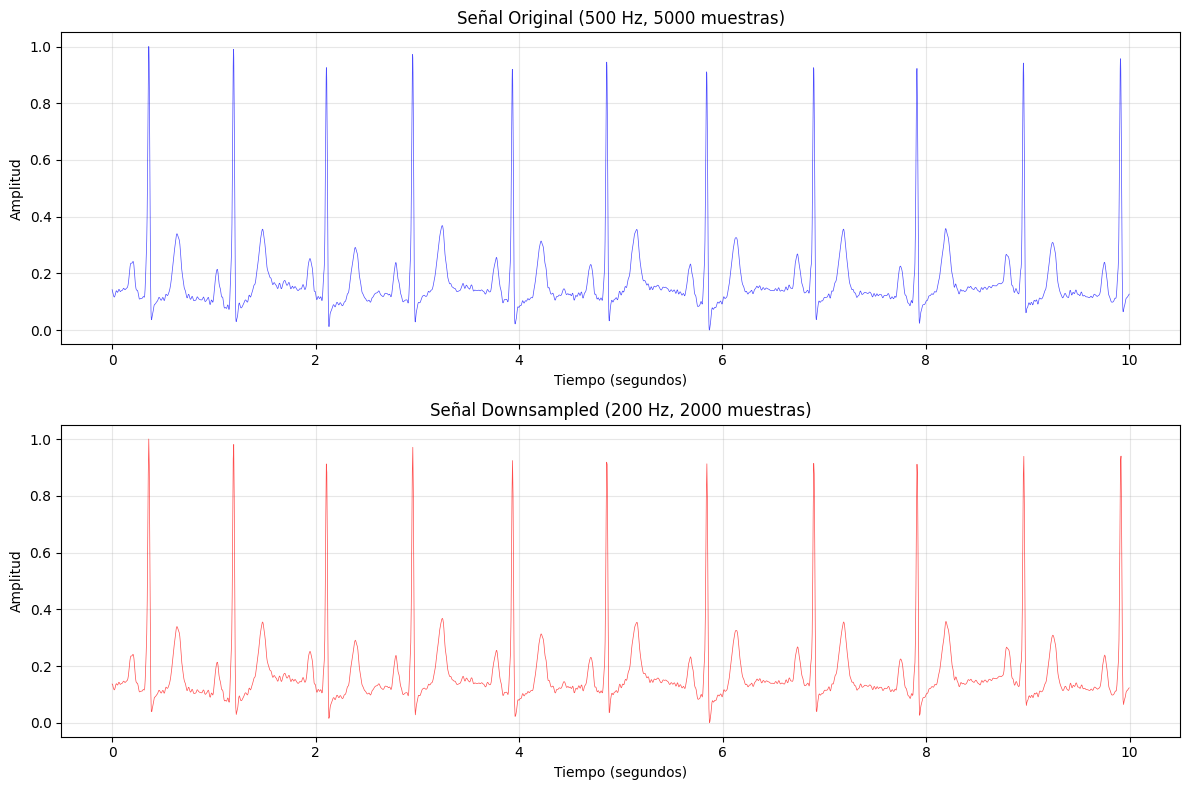

✅ Visualización completada
   Muestra 0, Lead II
   Original: 5000 muestras @ 500 Hz
   Downsampled: 2000 muestras @ 200 Hz


In [11]:
# ========================================
# Visualización opcional
# ========================================
import matplotlib.pyplot as plt

# Cargar una muestra de los datos originales (si existen)
original_file = numpy_dir / "X_train.npy"
downsampled_file = get_output_filename(original_file, OVERWRITE_ORIGINAL, USE_SEPARATE_FOLDER)

if original_file.exists() and downsampled_file.exists():
    print("📊 Cargando muestras para visualización...")
    
    # Cargar una muestra
    X_orig = np.load(original_file, mmap_mode='r')
    X_down = np.load(downsampled_file, mmap_mode='r')
    
    # Seleccionar una muestra aleatoria
    sample_idx = 0
    signal_orig = X_orig[sample_idx, :, 0]  # Lead II
    signal_down = X_down[sample_idx, :, 0]  # Lead II
    
    # Crear tiempo en segundos
    time_orig = np.arange(len(signal_orig)) / ORIGINAL_FS
    time_down = np.arange(len(signal_down)) / TARGET_FS
    
    # Visualizar
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Señal original
    axes[0].plot(time_orig, signal_orig, 'b-', linewidth=0.5, alpha=0.7)
    axes[0].set_title(f'Señal Original (500 Hz, {len(signal_orig)} muestras)', fontsize=12)
    axes[0].set_xlabel('Tiempo (segundos)')
    axes[0].set_ylabel('Amplitud')
    axes[0].grid(True, alpha=0.3)
    
    # Señal downsampled
    axes[1].plot(time_down, signal_down, 'r-', linewidth=0.5, alpha=0.7)
    axes[1].set_title(f'Señal Downsampled (200 Hz, {len(signal_down)} muestras)', fontsize=12)
    axes[1].set_xlabel('Tiempo (segundos)')
    axes[1].set_ylabel('Amplitud')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualización completada")
    print(f"   Muestra {sample_idx}, Lead II")
    print(f"   Original: {len(signal_orig)} muestras @ {ORIGINAL_FS} Hz")
    print(f"   Downsampled: {len(signal_down)} muestras @ {TARGET_FS} Hz")
else:
    print("⚠️ No se pueden cargar los archivos para visualización")


## 📝 Notas Importantes

**Después de ejecutar este notebook:**

1. **Actualizar configuración del modelo:**
   - En `lstm_classification_supervised.ipynb`, cambiar:
     - `SEQ_LEN = 2000` (en lugar de 5000)
     - Actualizar comentarios que mencionen "500 Hz" → "200 Hz"

2. **Usar los nuevos archivos:**
   - Si `USE_SEPARATE_FOLDER = True` (recomendado): Los archivos se guardan en:
     - `Datos_supervisados/numpy_200hz/` (archivos .npy)
     - `Datos_supervisados/tensors_200hz/` (archivos .pt)
   - Si `USE_SEPARATE_FOLDER = False`: Los archivos se guardan en las mismas carpetas con sufijo `_200hz`
   - Si `OVERWRITE_ORIGINAL = True`: Sobrescribe los archivos originales (¡cuidado!)
   - Necesitarás actualizar las rutas en el código de carga de datos según la opción elegida

3. **Memoria:**
   - Los archivos nuevos son ~2.5x más pequeños
   - Esto debería ayudar con problemas de memoria durante el entrenamiento

4. **Calidad de señal:**
   - `scipy.signal.resample` aplica filtrado anti-aliasing automáticamente
   - La calidad de la señal se mantiene adecuada para análisis ECG
